In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils


# --- Hyperparameters ---
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 15
BETA = 2000  # Weight on reconstruction loss
LOAD_MODEL = False
DEVICE = "cuda"

In [ ]:
!pip install kagglehub[pandas-datasets]

In [4]:
!kaggle datasets download jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [01:01<00:00, 23.3MB/s]
100% 1.33G/1.33G [01:01<00:00, 23.4MB/s]


In [ ]:
!unzip celeba-dataset.zip

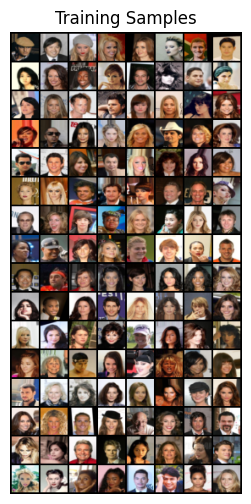

In [7]:
# Path to CelebA images
DATA_PATH = "img_align_celeba/img_align_celeba"

# Transforms: resize to 32x32 and normalize to [0,1]
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()  # values in [0,1]
])

# Dataset & DataLoader
train_dataset = datasets.ImageFolder(
    root=os.path.dirname(DATA_PATH),  # Folder containing subfolder "img_align_celeba"
    transform=transform
)
# NB: If you have a specific folder structure, adjust accordingly

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# Utility: show a batch of faces
def show_batch(images, title=""):
    grid_img = utils.make_grid(images, nrow=8)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis("off")
    plt.show()

# Test: Show a sample batch
data_iter = iter(train_loader)
images, _ = next(data_iter)
show_batch(images, title="Training Samples")

In [8]:
class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.z_dim = z_dim

        self.net = nn.Sequential(
            nn.Conv2d(CHANNELS, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES), #Batch normalisation
            nn.LeakyReLU(0.2, inplace=True), #activation functuon

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES), #Batch normalisation
            nn.LeakyReLU(0.2, inplace=True),  #activation functuon

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES), #Batch normalisation
            nn.LeakyReLU(0.2, inplace=True),  #activation functuon

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Flatten + produce mu & logvar
        # The output shape must be found dynamically
        # Hardcode if you know the shape after 4 conv layers
        # If IMAGE_SIZE=32 & 4 strided layers of stride=2 => output is 2x2
        self.flatten = nn.Flatten()
        # 2x2 out => size is (NUM_FEATURES * 2 * 2) = 128 * 2 * 2
        fc_in_features = NUM_FEATURES * (IMAGE_SIZE // 2**4) ** 2
        self.mu = nn.Linear(fc_in_features, z_dim)
        self.logvar = nn.Linear(fc_in_features, z_dim)

    def forward(self, x):
        x = self.net(x)
        x = self.flatten(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

In [9]:
class Sampling(nn.Module):
    def forward(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + logvar * eps

In [10]:
class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.z_dim = z_dim

        # Reverse of flatten
        fc_out_features = NUM_FEATURES * (IMAGE_SIZE // 2**4) ** 2
        self.fc = nn.Sequential(
            nn.Linear(z_dim, fc_out_features),
            nn.BatchNorm1d(fc_out_features),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.deconv = nn.Sequential(
            # Reshape => (N, NUM_FEATURES, 2, 2) if 4 strided layers used
            # We'll reshape in forward()

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, CHANNELS, 3, stride=2, padding=1, output_padding=1),
            # Output: (CHANNELS, 32, 32)
            nn.Sigmoid()  # since we want [0,1] output
        )

    def forward(self, z):
        x = self.fc(z)
        # Reshape -> (N, NUM_FEATURES, 2, 2)
        x = x.view(-1, NUM_FEATURES, (IMAGE_SIZE // 2**4), (IMAGE_SIZE // 2**4))
        x = self.deconv(x)
        return x


In [11]:
class VAE(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.sampling = Sampling()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.sampling(mu, logvar)
        recon = self.decoder(z)
        return mu, logvar, recon, z

In [12]:
def vae_loss_fn(x, recon, mu, logvar, beta=BETA):
    """
    x, recon: shape (N, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    mu, logvar: shape (N, Z_DIM)
    """
    # 1) Reconstruction Loss (MSE or BCE)
    # - Following your TF code => MSELoss with a BETA factor
    recon_loss = F.mse_loss(recon, x, reduction="sum")

    # 2) KL Divergence
    # kl_loss ~ -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
    kl_loss = kl / x.size(0)

    total_loss = recon_loss + kl_loss * (beta / x.size(0))

    return total_loss, recon_loss, kl_loss

if LOAD_MODEL and os.path.exists("./models/vae.pt"):
    print("Loading existing model...")
    model.load_state_dict(torch.load("./models/vae.pt"))


In [18]:
from tqdm import tqdm

model = VAE().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    model.train()
    total_loss_val = 0.0
    total_rec_val = 0.0
    total_kl_val = 0.0
    tqdm_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for (x, _) in tqdm_loader:
        x = x.to(DEVICE)
        optimizer.zero_grad()

        mu, logvar, recon, _ = model(x)
        loss, rec_loss, kl_loss = vae_loss_fn(x, recon, mu, logvar, BETA)

        loss.backward()
        optimizer.step()

        total_loss_val += loss.item()
        total_rec_val += rec_loss.item()
        total_kl_val += kl_loss.item()

        tqdm_loader.set_postfix(loss=loss.item())


    avg_loss = total_loss_val / len(train_loader)
    avg_rec = total_rec_val / len(train_loader)
    avg_kl = total_kl_val / len(train_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Recon: {avg_rec:.4f} | KL: {avg_kl:.4f}")

Epoch 1/30: 100%|██████████| 1582/1582 [02:32<00:00, 10.36it/s, loss=3.77e+3]


Epoch [1/30] | Loss: 6481.2758 | Recon: 6347.0113 | KL: 8.5929


Epoch 2/30: 100%|██████████| 1582/1582 [02:30<00:00, 10.50it/s, loss=2.97e+3]


Epoch [2/30] | Loss: 3270.5369 | Recon: 3231.3648 | KL: 2.5070


Epoch 3/30: 100%|██████████| 1582/1582 [02:32<00:00, 10.36it/s, loss=2.54e+3]


Epoch [3/30] | Loss: 2718.3188 | Recon: 2690.2664 | KL: 1.7954


Epoch 4/30: 100%|██████████| 1582/1582 [02:30<00:00, 10.54it/s, loss=2.21e+3]


Epoch [4/30] | Loss: 2409.7901 | Recon: 2385.2885 | KL: 1.5681


Epoch 5/30: 100%|██████████| 1582/1582 [02:32<00:00, 10.35it/s, loss=2.01e+3]


Epoch [5/30] | Loss: 2208.1864 | Recon: 2185.5537 | KL: 1.4485


Epoch 6/30: 100%|██████████| 1582/1582 [02:28<00:00, 10.64it/s, loss=1.84e+3]


Epoch [6/30] | Loss: 2061.3415 | Recon: 2040.0342 | KL: 1.3637


Epoch 7/30: 100%|██████████| 1582/1582 [02:32<00:00, 10.40it/s, loss=2.02e+3]


Epoch [7/30] | Loss: 1935.9319 | Recon: 1915.4094 | KL: 1.3134


Epoch 8/30: 100%|██████████| 1582/1582 [02:33<00:00, 10.33it/s, loss=1.9e+3]


Epoch [8/30] | Loss: 1805.5264 | Recon: 1785.7260 | KL: 1.2672


Epoch 9/30: 100%|██████████| 1582/1582 [02:30<00:00, 10.48it/s, loss=1.67e+3]


Epoch [9/30] | Loss: 1711.7216 | Recon: 1692.3830 | KL: 1.2377


Epoch 10/30: 100%|██████████| 1582/1582 [02:30<00:00, 10.53it/s, loss=1.73e+3]


Epoch [10/30] | Loss: 1643.4395 | Recon: 1624.6877 | KL: 1.2001


Epoch 11/30: 100%|██████████| 1582/1582 [02:33<00:00, 10.33it/s, loss=1.78e+3]


Epoch [11/30] | Loss: 1587.6128 | Recon: 1569.2362 | KL: 1.1761


Epoch 12/30: 100%|██████████| 1582/1582 [02:28<00:00, 10.63it/s, loss=1435.0]


Epoch [12/30] | Loss: 1534.1868 | Recon: 1516.2332 | KL: 1.1490


Epoch 13/30: 100%|██████████| 1582/1582 [02:34<00:00, 10.27it/s, loss=1.49e+3]


Epoch [13/30] | Loss: 1491.0571 | Recon: 1473.4465 | KL: 1.1271


Epoch 14/30: 100%|██████████| 1582/1582 [02:34<00:00, 10.24it/s, loss=1.4e+3]


Epoch [14/30] | Loss: 1446.6055 | Recon: 1429.5079 | KL: 1.0942


Epoch 15/30: 100%|██████████| 1582/1582 [02:34<00:00, 10.27it/s, loss=1.35e+3]


Epoch [15/30] | Loss: 1411.0442 | Recon: 1394.2705 | KL: 1.0735


Epoch 16/30: 100%|██████████| 1582/1582 [02:34<00:00, 10.27it/s, loss=1.35e+3]


Epoch [16/30] | Loss: 1380.0980 | Recon: 1363.5489 | KL: 1.0591


Epoch 17/30: 100%|██████████| 1582/1582 [02:33<00:00, 10.33it/s, loss=1.45e+3]


Epoch [17/30] | Loss: 1350.7493 | Recon: 1334.4011 | KL: 1.0463


Epoch 18/30: 100%|██████████| 1582/1582 [02:34<00:00, 10.26it/s, loss=1.35e+3]


Epoch [18/30] | Loss: 1323.3380 | Recon: 1307.3677 | KL: 1.0221


Epoch 19/30: 100%|██████████| 1582/1582 [02:34<00:00, 10.22it/s, loss=1.27e+3]


Epoch [19/30] | Loss: 1293.3404 | Recon: 1277.7200 | KL: 0.9997


Epoch 20/30: 100%|██████████| 1582/1582 [02:33<00:00, 10.32it/s, loss=1.23e+3]


Epoch [20/30] | Loss: 1273.3058 | Recon: 1257.8755 | KL: 0.9875


Epoch 21/30: 100%|██████████| 1582/1582 [02:31<00:00, 10.47it/s, loss=1.24e+3]


Epoch [21/30] | Loss: 1251.7484 | Recon: 1236.5387 | KL: 0.9734


Epoch 22/30: 100%|██████████| 1582/1582 [02:37<00:00, 10.06it/s, loss=1.22e+3]


Epoch [22/30] | Loss: 1232.9615 | Recon: 1217.9836 | KL: 0.9586


Epoch 23/30: 100%|██████████| 1582/1582 [02:38<00:00, 10.00it/s, loss=1.13e+3]


Epoch [23/30] | Loss: 1210.9250 | Recon: 1196.1462 | KL: 0.9458


Epoch 24/30: 100%|██████████| 1582/1582 [02:39<00:00,  9.92it/s, loss=1.13e+3]


Epoch [24/30] | Loss: 1191.7138 | Recon: 1177.1295 | KL: 0.9334


Epoch 25/30: 100%|██████████| 1582/1582 [02:38<00:00,  9.96it/s, loss=1.1e+3]


Epoch [25/30] | Loss: 1175.7976 | Recon: 1161.4116 | KL: 0.9207


Epoch 26/30: 100%|██████████| 1582/1582 [02:40<00:00,  9.87it/s, loss=1.16e+3]


Epoch [26/30] | Loss: 1157.6609 | Recon: 1143.5380 | KL: 0.9039


Epoch 27/30: 100%|██████████| 1582/1582 [02:35<00:00, 10.17it/s, loss=1.14e+3]


Epoch [27/30] | Loss: 1143.8076 | Recon: 1129.7393 | KL: 0.9004


Epoch 28/30: 100%|██████████| 1582/1582 [02:36<00:00, 10.10it/s, loss=1.1e+3]


Epoch [28/30] | Loss: 1127.3277 | Recon: 1113.5839 | KL: 0.8796


Epoch 29/30:   7%|▋         | 117/1582 [00:11<02:08, 11.39it/s, loss=1.2e+3]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4a285db7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Epoch 29/30: 100%|██████████| 1582/1582 [02:36<00:00, 10.12it/s, loss=1.05e+3]


Epoch [29/30] | Loss: 1115.0927 | Recon: 1101.4550 | KL: 0.8728


Epoch 30/30:   7%|▋         | 106/1582 [00:10<02:07, 11.59it/s, loss=1.02e+3]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4a285db7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Epoch 30/30:   7%|▋         | 116/1582 [00:11<02:16, 10.73it/s, loss=1.13e+3]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4a285db7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/d

Epoch [30/30] | Loss: 1103.1631 | Recon: 1089.6931 | KL: 0.8621


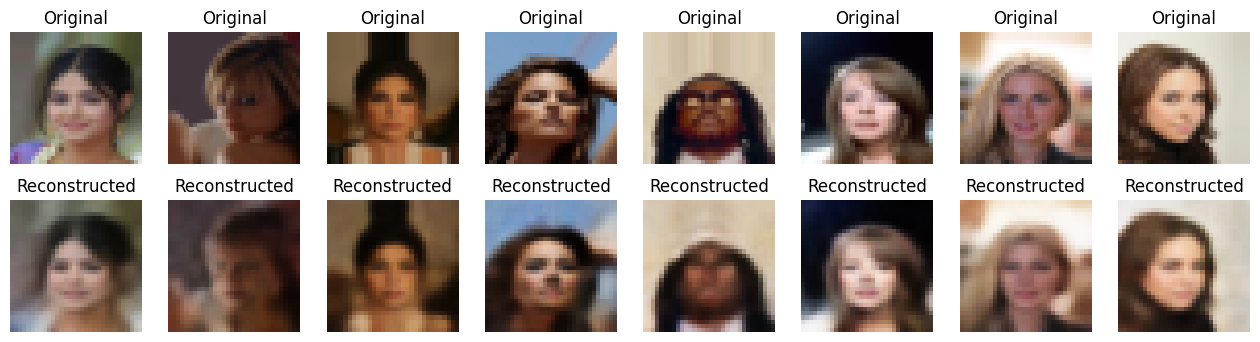

In [ ]:
# Save the final model
os.makedirs("./models", exist_ok=True)
torch.save(model.state_dict(), "./models/vae_face.pth")

model.eval()

# Take a small batch to reconstruct
data_iter = iter(train_loader)
images, _ = next(data_iter)
images = images[:8].to(DEVICE)

with torch.no_grad():
    mu, logvar, recon,_ = model(images)

# Visualize original vs. reconstructions
def show_reconstructions(orig, recon):
    """
    Show original (top row) and reconstructions (bottom row).
    """
    n = orig.size(0)
    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i+1)
        plt.imshow(orig[i].permute(1,2,0).cpu().numpy())
        plt.title("Original")
        plt.axis("off")

    for i in range(n):
        # Recon
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i].permute(1,2,0).detach().cpu().numpy())
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

show_reconstructions(images, recon)

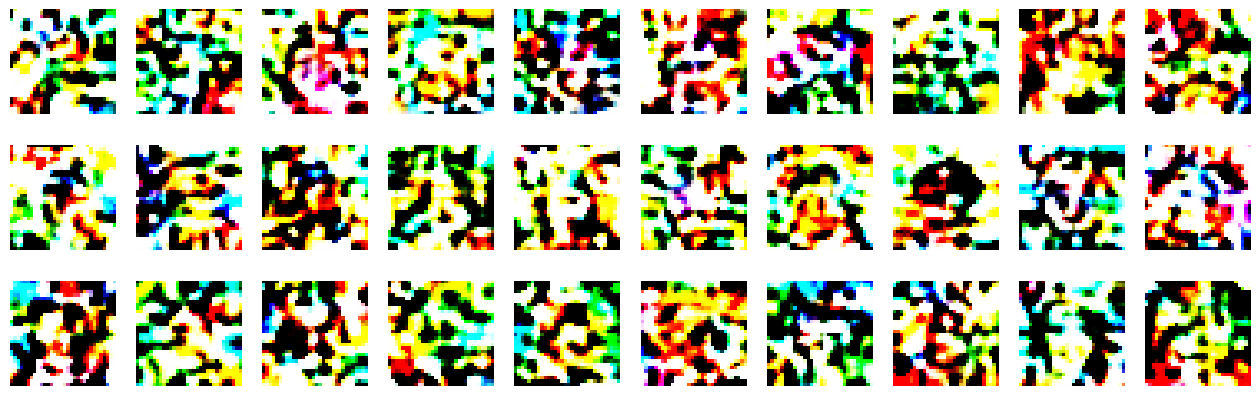

In [21]:
model.eval()

grid_width, grid_height = 10, 3
z_sample = torch.randn((grid_width*grid_height, Z_DIM)).to(DEVICE)

with torch.no_grad():
    recon = model.decoder(z_sample).detach()

# Plot the generated images
def show_generated(recon, w=grid_width, h=grid_height):
    recon = recon.cpu()
    fig = plt.figure(figsize=(16, 5))
    for i in range(w*h):
        ax = fig.add_subplot(h, w, i+1)
        ax.axis("off")
        ax.imshow(recon[i].permute(1,2,0).numpy())
    plt.show()

show_generated(recon)
